**第3章 分类**

@Author: Rui Zhu<br>
@Date: 2025-01-07

In [86]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

dir_data = Path("/Users/rui/Code/Astronote/05_Scikit-Learn/book2_机器学习实战/data")

---
# MNIST数据集

In [15]:
from sklearn.datasets import fetch_openml, load_digits

mnist = fetch_openml('mnist_784', as_frame=False, data_home=dir_data)

In [27]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape  # 7w张图像, 每张图像有784个特征即28x28像素

((70000, 784), (70000,))

True label: 7


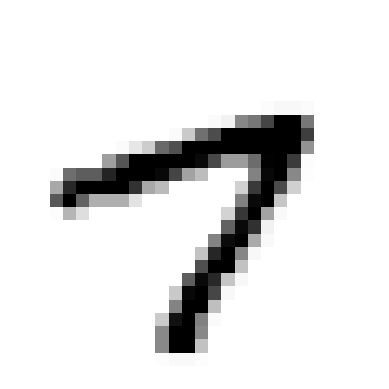

In [36]:
# 显示样本图像
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

idx = 101
plot_digit(X[idx])
print(f"True label: {y[idx]}")

In [39]:
# 测试集划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)
print(f"N of train set: {len(X_train)}, N of test set: {len(X_test)}")

N of train set: 60000, N of test set: 10000


---
# 二元分类器
- 多分类任务可以看作多个二分类器的组合
- 作为实例, 这里做一个“5检测器”

In [43]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# 训练模型
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

True label: 5
Predict: [ True]


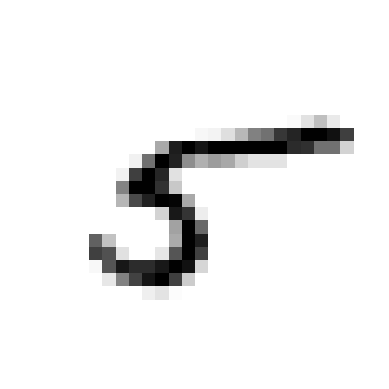

In [45]:
# 随机检查

idx = 105
print(f"True label: {y_test[idx]}")
print(f"Predict: {sgd_clf.predict([X_test[idx]])}")
plot_digit(X_test[idx])

---
# 分类器的性能评估

## 交叉验证
- 交叉验证是评估模型的一种方法
- k折交叉验证指: 将训练集分成k个折叠, 然后做k次训练, 每次使用其中一个折叠作为验证集, 其余数据用于训练

In [47]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9629 , 0.96775, 0.96435])

In [56]:
# 虚构的分类器
# 说明在不平衡的样本中, 即便全部预测为负样本, 也能有很高的准确率
# 说明准确率不是一个好的评价指标, 尤其在不平衡的数据集中
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # any()函数有True则True, 没有True则False

False


In [55]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9104, 0.9104, 0.9104])

In [57]:
# 手动实现交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9546
0.9709
0.96305


## 混淆矩阵
- accuracy在不平衡样本中会表现出欺骗性, 更好的性能评估是查看混淆矩阵

In [58]:
# 使用cross_val_predict()函数得到交叉验证的预测结果
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[54103,   521],
       [ 1579,  3797]])

In [63]:
# 一个完美的预测
y_train_perfect_pred = y_train_5
cm_perfect = confusion_matrix(y_train_5, y_train_perfect_pred)
cm_perfect

array([[54624,     0],
       [    0,  5376]])

## 准确率与召回率
- 准确率(percision): $\rm{\frac{TP}{TP + FP}}$, 即预测的样本中有多少是正确的
- 召回率(recall): $\rm\frac{TP}{TP + FN}$, 即阳性样本中，有多少被正确预测

In [64]:
cm

array([[54103,   521],
       [ 1579,  3797]])

In [66]:
percision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f"Percision: {percision}, Recall: {recall}")

Percision: 0.8793422880963409, Recall: 0.7062872023809523


In [67]:
from sklearn.metrics import precision_score, recall_score

percision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(f"Percision: {percision}, Recall: {recall}")

Percision: 0.8793422880963409, Recall: 0.7062872023809523


## F1分数
- F1分数是准确率和召回率的调和平均: $\rm F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$
- 调和平均对低值赋予更高的权重
- 因此只有precision和recall都很高时, F1才会有较高的分数

In [68]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.783371157416959)

## 准确率和召回率作为阈值的函数
- percision-recall权衡:
    1. 分类器的结果是根据决策函数作为判断的, 预测分数大于阈值为阳性
    2. 升高决策阈值会提高准确率但会降低召回率

### 输出决策分数
- sklearn不允许直接设置阈值, 但可以访问决策分数

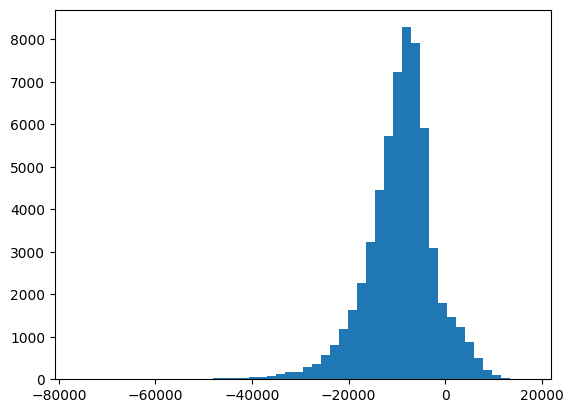

In [72]:
y_scores = sgd_clf.decision_function(X_train)
plt.hist(y_scores, bins=50);

In [73]:
# 获取训练集中所有实例的验证分数
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function'
    )

### PR-threshold curve

In [74]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Text(0, 0.5, 'Score')

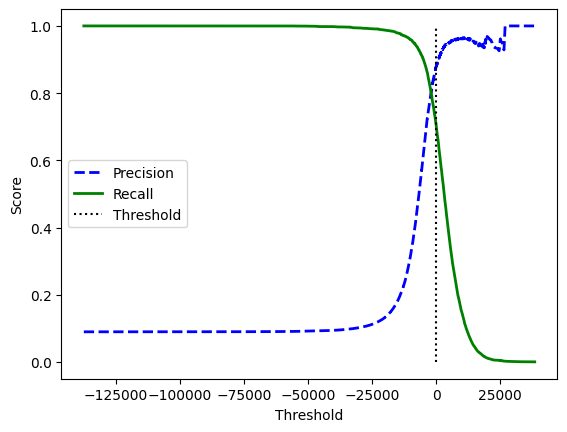

In [82]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
plt.vlines(5, 0, 1.0, 'k', 'dotted', label='Threshold')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")

## 准确率-召回率曲线
- PR Cure (percision-recall curve)

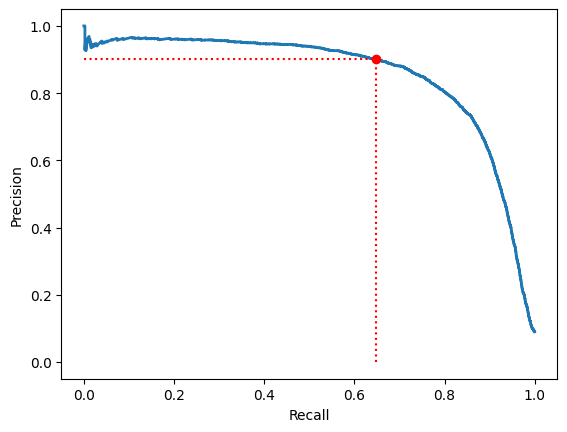

In [91]:
plt.plot(recalls, precisions, lw=2, label='Precision/Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")

# 搜索达到90%的准确率的最小阈值
idx = np.argmax(precisions >= 0.90)
threshold_90_precision = thresholds[idx]
percision_90 = precisions[idx]
recall_90 = recalls[idx]

plt.plot(recall_90, percision_90, 'ro')
plt.vlines(recall_90, 0, percision_90, 'r', 'dotted')
plt.hlines(percision_90, 0, recall_90, 'r', 'dotted')

In [92]:
# 输出更新阈值后的结果
y_train_pred_90 = (y_scores >= threshold_90_precision)
percision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)

print(f"Percision: {percision_90}, Recall: {recall_90}")

Percision: 0.9001293661060802, Recall: 0.6471354166666666


In [98]:
from sklearn.metrics import auc

# 计算PR曲线下的面积, 越接近1说明模型越好
auc(recalls, precisions)

np.float64(0.8539808206914135)

## ROC曲线
- 受试者操作特征(Receiver Operating Characteristic, ROC)